# Shor's algorithm in Qiskit

Disclaimer: some bugs may occur in this notebook and algorithm's implementations. If so, please report them on GitHub. Thanks :)

## Preparations

In [19]:
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.utils import QuantumInstance
from qiskit.visualization import plot_histogram

In [20]:
import sys
import logging

logging.basicConfig(level=logging.INFO)

for handler in logging.getLogger().handlers:
    handler.setLevel(logging.WARNING)

logger = logging.getLogger('implementations.shor')
logger.setLevel(logging.INFO)

if len(logger.handlers) == 0:
    handler = logging.StreamHandler(sys.stdout)
    handler.setLevel(logging.INFO)
    handler.setFormatter(logging.Formatter('%(name)s: %(message)s'))
    handler.addFilter(logging.Filter('implementations.shor'))
    logger.addHandler(handler)

Select numbers to test.

In [21]:
# N = 15, 21; also 35, 55 (for these, simulation will be long locally, up to 6 minutes)
N = 15

# 1 < a < N and gcd(a, N) = 1
a = 7

## Classical calculations

Compute classically reminders of `a^x mod N` for `x = 1, ..., 20`. Present results on graph, observe the period. For modular power, see https://docs.python.org/3.8/library/functions.html#pow

In [22]:
exponents = list(range(20))
values = []

for i in exponents:
    value = pow(a, i, mod=N)
    values.append(value)

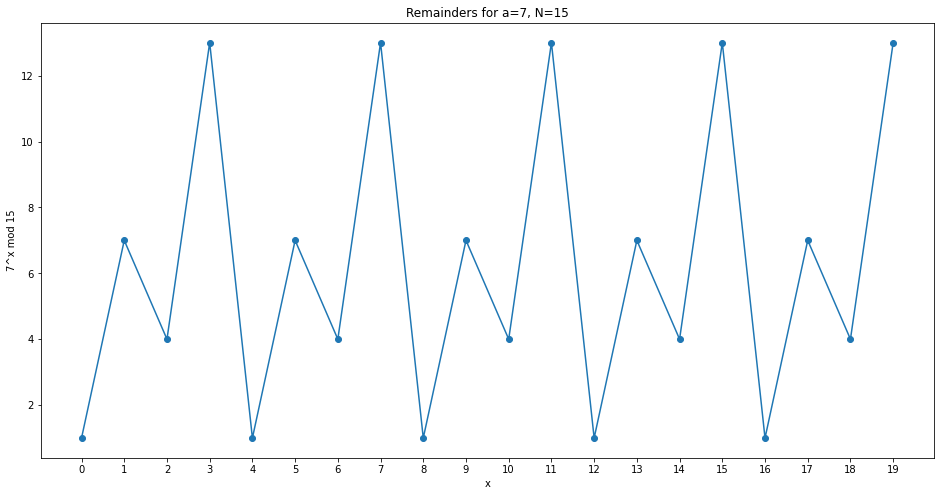

In [23]:
plt.figure(figsize=(16, 8))
plt.title(f'Remainders for a={a}, N={N}')
plt.xlabel('x')
plt.xticks(exponents)
plt.ylabel(f'{a}^x mod {N}')
plt.scatter(exponents, values)
plt.plot(exponents, values)
plt.show()

## Operation `a^x mod N` in Qiskit

Import gate for modular exponentiation. You can also use other implementations (mind the number of ancillary qubits).

In [24]:
from gates.mix.modular_exponentiation import modular_exponentiation_gate  # (n + 1 ancilla)

# from gates.takahashi.modular_exponentiation import modular_exponentiation_gate # (n + 1 ancilla)

# from gates.beauregard.modular_exponentiation import modular_exponentiation_gate # (n + 2 ancilla)

# from gates.haner.modular_exponentiation import modular_exponentiation_gate # (n + 1 ancilla, big size of circuit!)

Count width `n` of `N`.

In [25]:
n = N.bit_length()
print(n)

4


Create registers and circuit.

In [26]:
# input register
x_qreg = QuantumRegister(2 * n, name='x')

# output register, must contain 1
y_qreg = QuantumRegister(n, name='y')

In [27]:
# ancillary register; change the size according to selected implementation
ancillary_register_size = n + 1
aux_qreg = QuantumRegister(ancillary_register_size, name='aux')

In [28]:
circuit = QuantumCircuit(x_qreg, y_qreg, aux_qreg)

In [29]:
# prepare input register
circuit.h(x_qreg)

# prepare output register
circuit.x(y_qreg[0])

In [30]:
# append gate
gate = modular_exponentiation_gate(a, N, n)
circuit.append(gate, circuit.qubits)

In [31]:
# measure output register
y_creg = ClassicalRegister(n, name='yValue')
circuit.add_register(y_creg)
circuit.measure(y_qreg, y_creg)

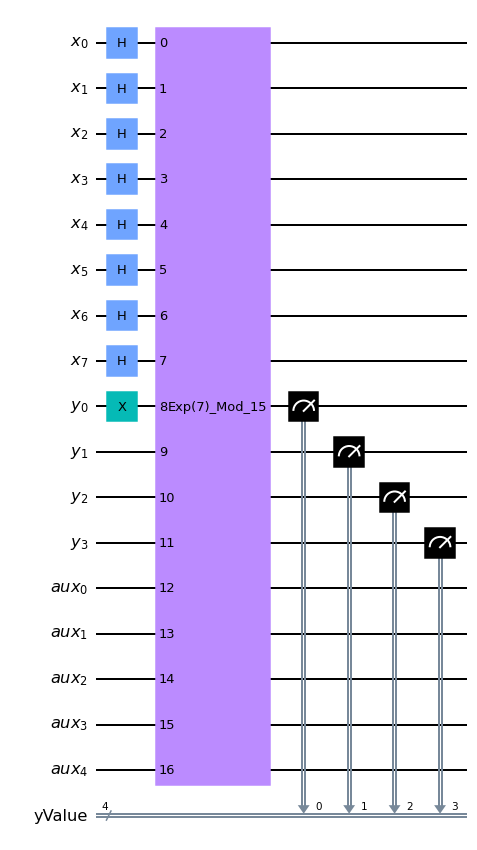

In [32]:
circuit.draw(output='mpl', fold=-1)

Run circuit. 
WARNING: ibmq_qasm_simulator is run on the IBM cloud infrastructure (not local!). 
Suggested when stronger machine is required (but mind the queue system!) 

In [33]:
def get_quantum_instance(cloud):
    if cloud:
        from qiskit import IBMQ
        provider = IBMQ.load_account()
        backend = provider.get_backend('ibmq_qasm_simulator')
    else:
        from qiskit.providers.aer import QasmSimulator
        backend = QasmSimulator()

    return QuantumInstance(backend)

In [34]:
instance = get_quantum_instance(cloud=False)
instance.set_config(shots=64)
exponentiation_result = instance.execute(circuit)

ImportError: cannot import name 'BaseBackend' from 'qiskit.providers' (C:\ProgramData\Anaconda3\lib\site-packages\qiskit\providers\__init__.py)

Draw histogram. Compare results with classical calculations.

In [ ]:
counts = exponentiation_result.get_counts(circuit)
plot_histogram(counts)

Let's try observe period.

In [ ]:
# clone circuit
circuit2 = circuit.copy()

# measure input register
x_creg = ClassicalRegister(2 * n, name='xValue')
circuit2.add_register(x_creg)
circuit2.measure(x_qreg, x_creg)

In [ ]:
instance.set_config(shots=128)
exponentiation_and_exponent_result = instance.execute(circuit2)

In [ ]:
counts = exponentiation_and_exponent_result.get_counts(circuit2)
values_map = {}
for measurement in counts.keys():
    x, y = [int(value, base=2) for value in measurement.split(' ')]
    values = values_map.get(y, [])
    values.append(x)
    values_map[y] = values

Print measured `x` values for each exponentiation result.
You should observe that values differs from each other by constant - period `r`. (precisely, only part of them
in different runs will - think why!)

In [ ]:
for y, x_values in values_map.items():
    print(y)
    print(sorted(x_values))
    print()

## Finding period / order in Qiskit

Import Shor's algorithm implementation.
Similarly to modular exponentiation gate, you can test different implementations.

In [ ]:
from implementations.mix import MixShor as Shor

# from implementations.takahashi import TakahashiShor as Shor

# from implementations.beauregard import BeauregardShor as Shor

# from implementations.haner import HanerShor as Shor # (big size of circuit!)

For usage, class instance have to be created.
WARNING: cloud=True means running  on the IBM cloud infrastructure (not local!). Suggested when stronger machine is required (but mind the queue system!) 

In [ ]:
instance = get_quantum_instance(cloud=False)
instance.set_config(shots=64)

# create instance of class
shor = Shor(instance)

Observe 3 parts of algorithm.

In [ ]:
circuit = shor.construct_circuit(a, N, semi_classical=False, measurement=True)
circuit.draw(output='mpl', fold=-1)

Invoke `get_order()` to run algorithm and post-process measurements. 
Setting `semi_classical` argument to `True` will run algorithm on optimized version of circuit.

In [ ]:
result = shor.get_order(a, N, semi_classical=True)

Print result. Compare it with earlier observed order.

In [ ]:
print(result.total_shots, result.successful_shots)
print(result.total_counts, result.successful_counts)
print(result.order)

## Bob's and Eva's algorithm

Use `get_order()` to perform tasks from laboratories.
For modular power and modular inverse see: https://docs.python.org/3/library/functions.html#pow

In [ ]:
# TODO by you :)